## Elementos finitos linear 1D

## Montar a matrix de massa

In [1]:
using Jacobi

## Funções

In [2]:
remap(x,a,b) = ((1-x)*a + (1+x)*b)/2

remap (generic function with 1 method)

In [3]:
function ψj(p,E,Q)
    if(p == 1)
     return  (1-E)/2
        elseif(p == 2)
     return  (1+E)/2
    else
     return  (1-E)*(1+E)/4 .* jacobi(E, p-3, 1, 1)
    end
end 

ψj (generic function with 1 method)

In [4]:
function dψj(p,E,Q)
    if(p == 1)
     return  (-1)/2
        elseif(p == 2)
     return  (1)/2
    else
        return  -E/2 *jacobi(E, p-3, 1, 1) + (1+E)*(1-E)/4 * djacobi(E,p-3,1,1)
    end
end 

dψj (generic function with 1 method)

In [5]:
function  ϕ_matrix(ψj,Q,M)
    ϕ = zeros(Q,M)
    ξ = zglj(Q)
    for i in 1:M
        for j in 1:Q
            ϕ[j,i] = ψj(i,ξ[j],M)
        end
    end
  return ϕ
end

ϕ_matrix (generic function with 1 method)

In [6]:
function  ϕ_matrix_interp(ψj,Q,M)
    ϕ = zeros(Q,M)
    ξ = linspace(-1,1,Q)
    for i in 1:M
        for j in 1:Q
            ϕ[j,i] = ψj(i,ξ[j],M)
        end
    end
  return ϕ
end

ϕ_matrix_interp (generic function with 1 method)

In [7]:
function Me_matrix(ϕ,w,M,Q,a,b)
    L = zeros(M,M)
    jac = (b-a)/2
    for i in 1:M
        for j in 1:M
           m= 0.0
            for q in 1:Q
                m = m + ϕ[q,i]*ϕ[q,j]*w[q]*jac
            end
            L[i,j] = m
        end
    end
    return L
end

Me_matrix (generic function with 1 method)

In [8]:
function Se_matrix(ϕ,w,M,Q,a,b)
    L = zeros(M,M)
    jac = (b-a)/2
    for i in 1:M
        for j in 1:M
           m= 0.0
            for q in 1:Q
                m = m + ϕ[q,i]*ϕ[q,j]*w[q]*jac^-1
            end
            L[i,j] = m
        end
    end
    return L
end

Se_matrix (generic function with 1 method)

### $ϕ$ e  matriz de massa

In [9]:
Nel = 10
I = 5
nb = Nel + 1
ni = (I-2)
Q = I+2

#indices locais
ib = collect(1:2)
ii = collect(3:I)

#limites
a = -1; 
b = 1;
#problema
fun(x) = (1.0 - 4*pi^2)*sin(2*pi*x) 
resp(x) = sin(2*pi*x)
cond_dir = [0.0,0.0]

z = zglj(Q)
w = wglj(z)
ϕ = ϕ_matrix(ψj,Q,I);
dϕ = ϕ_matrix(dψj,Q,I)
xn = [linspace(a,b,Nel+1);];
X = zeros(Q,Nel)
remap(x,a,b) = ((1-x)*a + (1+x)*b)/2
for e in 1:Nel
    X[:,e] = [remap(x,xn[e],xn[e+1]) for x in z]
end
X;

In [10]:

dof_map = zeros(Int, 2, Nel)
for i = 1:Nel
    dof_map[1,i] = i
    dof_map[2,i] = i+1
end
dof_map

2x10 Array{Int64,2}:
 1  2  3  4  5  6  7  8   9  10
 2  3  4  5  6  7  8  9  10  11

In [11]:

using Base.LinAlg.BLAS.gemm!
using Base.LinAlg.BLAS.gemv!
using Base.LinAlg.LAPACK.potrf!
using Base.LinAlg.LAPACK.potrs!

### $ A_{bb}^* = (A_{bb} - A_{bi} A_{ii}^{-1} A_{ib})  $

In [12]:
dp  = zeros(Nel +1)
dl  = zeros(Nel)
M = Vector{Array{Float64,2}}(Nel)
Mii = Vector{Array{Float64,2}}(Nel)
for e in 1:Nel
    Me = Me_matrix(ϕ, w, I, Q, xn[e], xn[e+1]) ;  #mass matrix
    Se = Se_matrix(dϕ, w, I, Q, xn[e], xn[e+1]) ; #stiff matrix
    Mbb = Me[ib,ib] - Se[ib,ib]
    Mbi = Me[ib,ii] - Se[ib,ii]
    Mib = Me[ii,ib] - Se[ii,ib]
    Mii[e] = Me[ii,ii] - Se[ii,ii]
    
    potrf!('L',Mii[e]); #Mii^-1
    M[e] = copy(Mib)
    potrs!('L',Mii[e],M[e]) # M = Mii^-1 * Mbi
    gemm!('T', 'N', -1.0, M[e], Mib, 1.0, Mbb) # Mbb = -1*M*Mib + Mbb
    
    for i in 1:2
        ig = dof_map[i,e]
        for j in 1:2
            jg = dof_map[j,e]
            if jg == ig #principal
                dp[jg] += Mbb[i,j]
            end
            if jg == ig + 1 && jg > 1#low
              dl[jg-1] += Mbb[i,j] 
            end
        end
    end
end
dp[1],dp[end] = 10^10,10^10
Abb = SymTridiagonal(dp,dl); 
Abb

11x11 SymTridiagonal{Float64}:
 1.0e10    5.03324   0.0       0.0      …   0.0       0.0      0.0    
 5.03324  -9.86687   5.03324   0.0          0.0       0.0      0.0    
 0.0       5.03324  -9.86687   5.03324      0.0       0.0      0.0    
 0.0       0.0       5.03324  -9.86687      0.0       0.0      0.0    
 0.0       0.0       0.0       5.03324      0.0       0.0      0.0    
 0.0       0.0       0.0       0.0      …   0.0       0.0      0.0    
 0.0       0.0       0.0       0.0          0.0       0.0      0.0    
 0.0       0.0       0.0       0.0          5.03324   0.0      0.0    
 0.0       0.0       0.0       0.0         -9.86687   5.03324  0.0    
 0.0       0.0       0.0       0.0          5.03324  -9.86687  5.03324
 0.0       0.0       0.0       0.0      …   0.0       5.03324  1.0e10 

In [13]:
fact = ldltfact!(Abb);

## RHS

In [14]:

#calcula F
Fe = zeros(I,Nel)
for e = 1:Nel
    jac = (xn[e+1] - xn[e] )/2
    for i in 1:I
        temp = 0.0
        for q in 1:Q
            temp += fun(X[q,e])* ϕ[q,i] * w[q] * jac
        end
        Fe[i,e] = temp
    end
end
Fe[1,1] = 0; Fe[2,end]= 0;#arrumar

0

In [15]:
Fe = Fe 

5x10 Array{Float64,2}:
  0.0        -3.66278    -0.77452       3.1841     …   3.1841      2.7424   
 -2.7424     -3.1841      0.77452       3.66278        3.66278     0.0      
 -0.724555   -1.17236     1.59595e-16   1.17236        1.17236     0.724555 
 -0.253518    0.0968351   0.313365      0.0968351      0.0968351  -0.253518 
  0.0249565   0.0403804   2.77556e-17  -0.0403804     -0.0403804  -0.0249565

### $f_b^* =f_b - A_{bi} A_{ii}^{-1} f_i$

In [16]:
Fb = zeros(nb)

for e in 1:Nel
    fe  = Fe[:,e]
    fb  = fe[ib]
    fi  = fe[ii]
    gemv!('T',-1.0,M[e],fi, 1.0, fb) #fbb = -1*M^T*fi + fb

    for i in 1:2
        ig = dof_map[i,e]
        Fb[ig] += fb[i]
    end

end
Fb;

# Solve   $A^*_{bb}\ u_b =\ f^*_b$

In [17]:
Ue = zeros(I,Nel)

#potrs!('L',Abb,Fb)
Ub = fact\Fb


11-element Array{Float64,1}:
 -4.75882e-10
  0.94633    
  0.584864   
 -0.584864   
 -0.94633    
  6.66134e-16
  0.94633    
  0.584864   
 -0.584864   
 -0.94633    
  4.75882e-10

### $u_i = A_{ii}^{-1}f_i - A_{ii}^{-1} A_{bi}^t u_b$

In [18]:
U = zeros(I,Nel)
for e in 1:Nel
    ub  = Ub[vec(dof_map[:,e])]
    fe  = Fe[:,e]
    fi  = fe[ii]

    potrs!('L',Mii[e],fi)
    gemv!('N',-1.0,M[e],ub,1.0,fi) #fi = -1*M*ub + fi
    
    U[ib,e] = ub
    U[ii,e] = fi
end
U 

5x10 Array{Float64,2}:
 -4.75882e-10   0.94633      0.584864     …  -0.584864    -0.94633    
  0.94633       0.584864    -0.584864        -0.94633      4.75882e-10
 -0.268663     -0.434707     3.26122e-12      0.434707     0.268663   
 -0.0162701     0.00621464   0.020111         0.00621464  -0.0162701  
  0.000619853   0.00100294  -1.86419e-16     -0.00100294  -0.000619853

In [19]:
Uh = zeros(Q,Nel)
for e in 1:Nel
    Uh[:,e] = ϕ*U[:,e]
end
Uh

7x10 Array{Float64,2}:
 -4.75882e-10  0.94633    0.584864     -0.584864  …  -0.584864  -0.94633    
  0.0616487    0.881218   0.482974     -0.582724     -0.582724  -0.843117   
  0.201905     0.764424   0.270535     -0.597224     -0.597224  -0.639639   
  0.405883     0.656732  -2.68774e-10  -0.656732     -0.656732  -0.405883   
  0.639639     0.597224  -0.270535     -0.764424     -0.764424  -0.201905   
  0.843117     0.582724  -0.482974     -0.881218  …  -0.881218  -0.0616487  
  0.94633      0.584864  -0.584864     -0.94633      -0.94633    4.75882e-10

In [20]:
using PyPlot

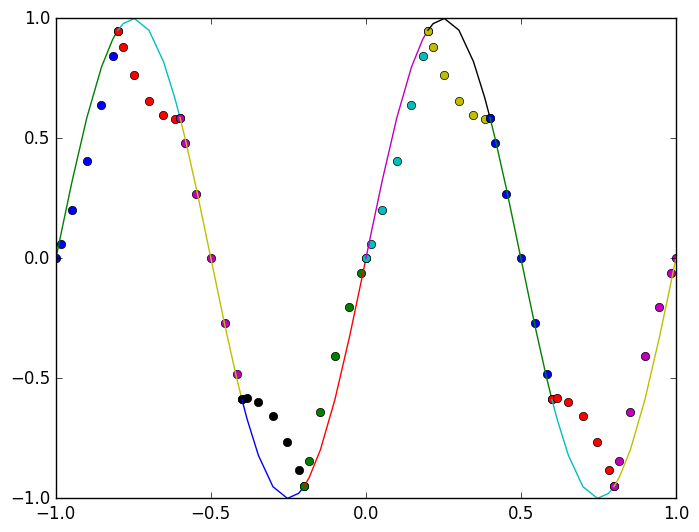

In [21]:

for e in 1:Nel
    plot(X[:,e],Uh[:,e],"o")
    y = [fun(x) for x in X[:,e] ]
    plot(X[:,e],[resp(x) for x in X[:,e] ])
    #legend()
end


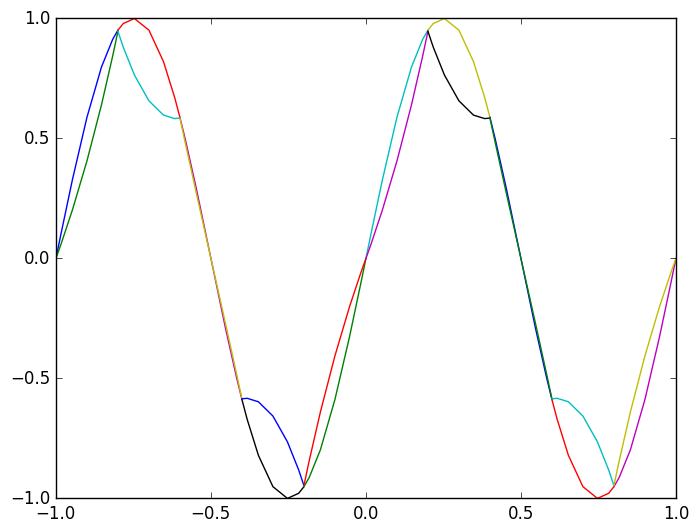

In [22]:

for e in 1:Nel
    plot(X[:,e],[resp(x) for x in X[:,e] ])
    plot(X[:,e],Uh[:,e])
end


In [23]:
Ue = resp(x)
erro = Uh - Ue
Ndof = nb + Nel*(ni)
Ndof,maxabs(erro)

LoadError: LoadError: UndefVarError: x not defined
while loading In[23], in expression starting on line 1